Column names in the CSV file: Index(['Name', 'I felt happy.', 'I felt engaged.', 'I felt comfortable.',
       'I felt safe and secure.', 'I enjoyed the company of other people.',
       'I talked to other people.', 'Comments', 'Sentiment Score'],
      dtype='object')
Sentiment scores appended to the CSV file at museum_wellbeing_survey/data/wellbeing_survey.csv
Average Sentiment Score: 0.16200439929962157


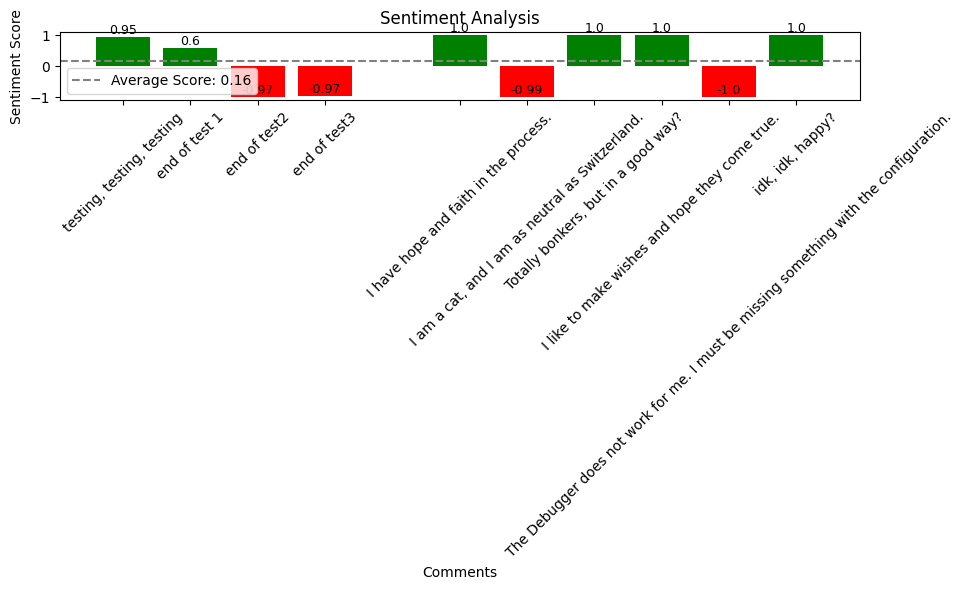

In [8]:
import torch
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from transformers import pipeline

# Define the file path
file_path = "museum_wellbeing_survey/data/wellbeing_survey.csv"

# Specify the model name DistilBERT model from Hugging Face fine-tuned on the Stanford Sentiment Treebank v2 (SST-2) dataset
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Create the sentiment analysis pipeline with the specified model
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

try:
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Print the column names to debug
    print("Column names in the CSV file:", df.columns)

    # Check if the column exists in the DataFrame
    if 'Comments' not in df.columns:
        print("Error: 'Comments' column not found in the CSV file.")
    else:
        # Perform sentiment analysis on the 'Comments' column
        sentiment_scores = []
        for comment in df['Comments']:
            if pd.isna(comment) or comment.strip() == "":
                sentiment_scores.append(0)  # Assign a sentiment score of 0 if there is no comment
            else:
                results = sentiment_pipeline(comment)
                score = results[0]['score'] if results[0]['label'] == 'POSITIVE' else -results[0]['score']
                sentiment_scores.append(score)

        # Add the sentiment scores as a new column to the DataFrame
        df['Sentiment Score'] = sentiment_scores

        # Save the updated DataFrame back to the CSV file
        df.to_csv(file_path, index=False)
        print(f"Sentiment scores appended to the CSV file at {file_path}")

        # Calculate the average sentiment score, excluding the 0 scores
        non_zero_scores = list(filter(lambda x: x != 0, sentiment_scores))
        if non_zero_scores:
            average_score = sum(non_zero_scores) / len(non_zero_scores)
            print(f"Average Sentiment Score: {average_score}")
        else:
            average_score = 0
            print("No comments to analyze for sentiment.")

        # Create a DataFrame to store the sentiment scores and optional comments
        df_sentiment = df[df['Sentiment Score'] != 0]

        # Create bar chart with colored bars based on sentiment score
        colors = ['green' if score >= 0 else 'red' for score in df_sentiment['Sentiment Score']]
        plt.figure(figsize=(10, 6))
        bars = plt.bar(df_sentiment.index, df_sentiment['Sentiment Score'], color=colors)

        # Add labels, title, and axis labels
        plt.title('Sentiment Analysis')
        plt.xlabel('Comments')
        plt.ylabel('Sentiment Score')
        plt.xticks(df_sentiment.index, df_sentiment['Comments'], rotation=45)  # Rotate x-axis labels if needed

        # Add value labels on top of the bars
        for bar, score in zip(bars, df_sentiment['Sentiment Score']):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{round(score, 2)}',
                     ha='center', va='bottom', fontsize=9)

        # Add horizontal line for average sentiment score
        plt.axhline(y=average_score, color='gray', linestyle='--', label=f'Average Score: {round(average_score, 2)}')

        plt.legend()  # Show legend with average score
        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")  # In case file is not found at the path
except Exception as e:
    print(f"An error occurred: {e}")  # Catch other errors
